In [42]:
# libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, homogeneity_completeness_v_measure
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from folium.plugins import HeatMap
from kneed import KneeLocator

In [27]:
# import data
time_series_data = pd.read_csv('../data/processed/dog_bite_time_series.csv')
wrangled = time_series_data.drop(columns=['borough'])

# display
wrangled.head()

,week1,week2,week3,week4,week5,week6,week7,week8,week9,week10,...,week409,week410,week411,week412,week413,week414,week415,week416,week417,week418
0,3.0,5.0,9.0,12.0,8.0,16.0,10.0,6.0,10.0,9.0,...,11.0,16.0,12.0,9.0,10.0,18.0,10.0,8.0,9.0,13.0
1,11.0,10.0,5.0,8.0,11.0,11.0,15.0,9.0,12.0,7.0,...,9.0,11.0,13.0,10.0,8.0,7.0,10.0,11.0,6.0,8.0
2,5.0,12.0,8.0,16.0,6.0,15.0,12.0,8.0,10.0,15.0,...,21.0,19.0,17.0,7.0,12.0,18.0,17.0,11.0,10.0,7.0
3,11.0,7.0,7.0,10.0,8.0,8.0,7.0,13.0,14.0,15.0,...,15.0,21.0,10.0,8.0,15.0,12.0,15.0,7.0,12.0,14.0
4,2.0,3.0,8.0,5.0,7.0,6.0,3.0,10.0,1.0,8.0,...,4.0,7.0,6.0,5.0,6.0,2.0,4.0,4.0,3.0,2.0


In [34]:
# Standardize the data across the entire dataframe
scaler = MinMaxScaler()
wrangled_scaled = scaler.fit_transform(wrangled.values.flatten().reshape(-1, 1)).reshape(wrangled.shape)

# Convert back to DataFrame
wrangled_scaled = pd.DataFrame(wrangled_scaled, columns=wrangled.columns)

wrangled_scaled.head()

,week1,week2,week3,week4,week5,week6,week7,week8,week9,week10,...,week409,week410,week411,week412,week413,week414,week415,week416,week417,week418
0,0.078947,0.131579,0.236842,0.315789,0.210526,0.421053,0.263158,0.157895,0.263158,0.236842,...,0.289474,0.421053,0.315789,0.236842,0.263158,0.473684,0.263158,0.210526,0.236842,0.342105
1,0.289474,0.263158,0.131579,0.210526,0.289474,0.289474,0.394737,0.236842,0.315789,0.184211,...,0.236842,0.289474,0.342105,0.263158,0.210526,0.184211,0.263158,0.289474,0.157895,0.210526
2,0.131579,0.315789,0.210526,0.421053,0.157895,0.394737,0.315789,0.210526,0.263158,0.394737,...,0.552632,0.500000,0.447368,0.184211,0.315789,0.473684,0.447368,0.289474,0.263158,0.184211
3,0.289474,0.184211,0.184211,0.263158,0.210526,0.210526,0.184211,0.342105,0.368421,0.394737,...,0.394737,0.552632,0.263158,0.210526,0.394737,0.315789,0.394737,0.184211,0.315789,0.368421
4,0.052632,0.078947,0.210526,0.131579,0.184211,0.157895,0.078947,0.263158,0.026316,0.210526,...,0.105263,0.184211,0.157895,0.131579,0.157895,0.052632,0.105263,0.105263,0.078947,0.052632


In [35]:
results = {}

for min_samples in range(2, min(len(wrangled), 20)):  # Test a range of min_samples values
    # print(f"min_samples: {min_samples}")
# for min_samples in range(100, 150, 2):  # Test a range of min_samples values
    nearest_neighbors = NearestNeighbors(n_neighbors=min_samples)
    nearest_neighbors.fit(wrangled)
    distances, indices = nearest_neighbors.kneighbors(wrangled)

    # Sort the distances to the k-th nearest neighbor
    k_distances = distances[:, min_samples-1]  # k-th nearest neighbor distances
    k_distances = np.sort(k_distances)

    kneedle = KneeLocator(range(len(k_distances)), k_distances, curve="convex", direction="increasing")
    eps_value = kneedle.knee
    # print(f"Optimal epsilon value: {k_distances[eps_value]}")
        
        # copy wrangled to clustered
    clustered = wrangled.copy()

    # DBSCAN clustering
    if k_distances[eps_value] < 0.1:
        continue
    dbscan = DBSCAN(eps=k_distances[eps_value], min_samples=min_samples)
    clusters = dbscan.fit_predict(wrangled)
    
    # print(f"Number of clusters: {len(set(clusters))}")
    
    # Exclude cases where all points are noise
    if len(set(clusters)) > 1:
        score = silhouette_score(wrangled, clusters)
        db_score = davies_bouldin_score(wrangled, clusters)
        ari_score = adjusted_rand_score(time_series_data['borough'], clusters)
        homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(time_series_data['borough'], clusters)
        
        results[min_samples] = {
            'n_clusters': len(set(clusters)),
            'eps': k_distances[eps_value],
            'silhouette_score': score,
            'davies_bouldin_score': db_score,
            'adjusted_rand_score': ari_score,
            'homogeneity': homogeneity,
            'completeness': completeness,
            'v_measure': v_measure
        }

# Find the best min_samples value
best_min_samples = max(results, key=lambda x: results[x]['silhouette_score'])
print(f"Best min_samples: {best_min_samples}")


Best min_samples: 2


In [36]:
# Perform DBSCAN clustering with best_min_samples
optimal_eps = results[best_min_samples]['eps']
dbscan_optimal = DBSCAN(eps=optimal_eps, min_samples=best_min_samples)
clusters_optimal = dbscan_optimal.fit_predict(wrangled_scaled)

# Add the cluster labels to the original dataframe
time_series_data['cluster'] = clusters_optimal

# Display the boroughs and their corresponding clusters
clustered_boroughs = time_series_data[['borough', 'cluster']]
print(clustered_boroughs)

         borough  cluster
0          bronx        0
1       brooklyn        0
2      manhattan        0
3         queens        0
4  staten island        0


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_38024\3438513937.py:8: SyntaxWarning: invalid escape sequence '\d'
  melted_data['week'] = melted_data['week'].str.extract('(\d+)')


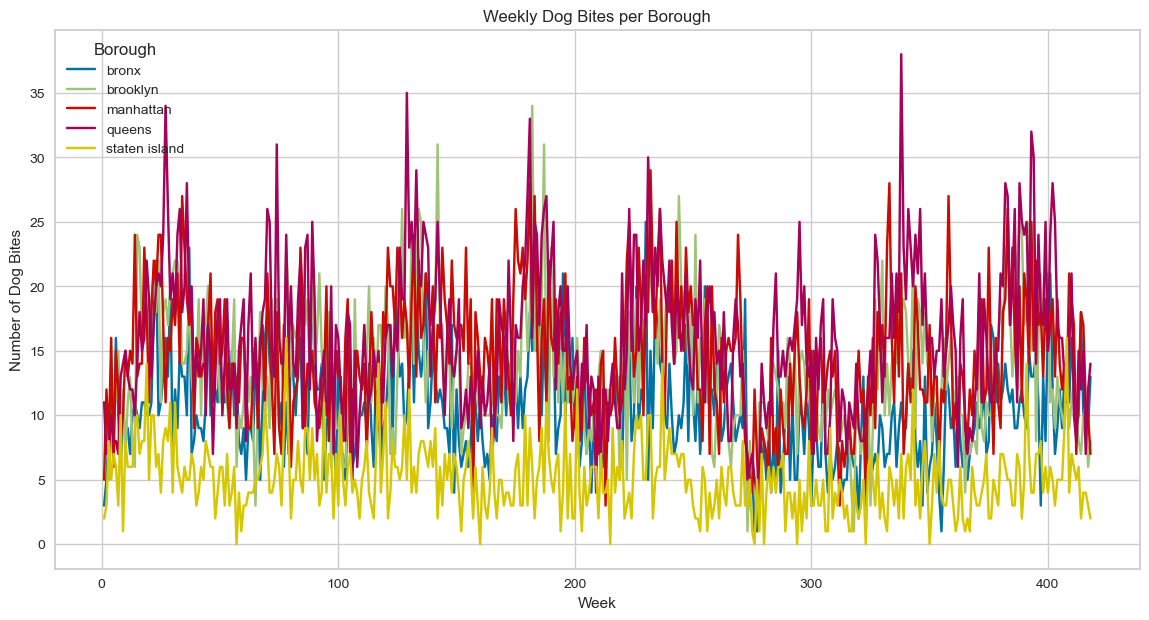

In [40]:
# Melt the dataframe to long format for seaborn
melted_data = pd.melt(time_series_data, id_vars=['borough'], var_name='week', value_name='bites')

# Drop rows with NaN values in 'week' column
melted_data = melted_data.dropna(subset=['week'])

# Extract week numbers and drop rows with NaN values in 'week' column
melted_data['week'] = melted_data['week'].str.extract('(\d+)')
melted_data = melted_data.dropna(subset=['week'])

# Convert week to integer for proper plotting
melted_data['week'] = melted_data['week'].astype(int)

# Plot using seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=melted_data, x='week', y='bites', hue='borough')
plt.title('Weekly Dog Bites per Borough')
plt.xlabel('Week')
plt.ylabel('Number of Dog Bites')
plt.legend(title='Borough')
# Replace NaN values in 'bites' column with 0
melted_data['bites'] = melted_data['bites'].fillna(0)

plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_38024\233379121.py:17: SyntaxWarning: invalid escape sequence '\d'
  melted_monthly_data['month'] = melted_monthly_data['month'].str.extract('(\d+)')
C:\Users\User\AppData\Local\Temp\ipykernel_38024\233379121.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_data[month_col] = monthly_data[week_cols].sum(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_38024\233379121.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragm

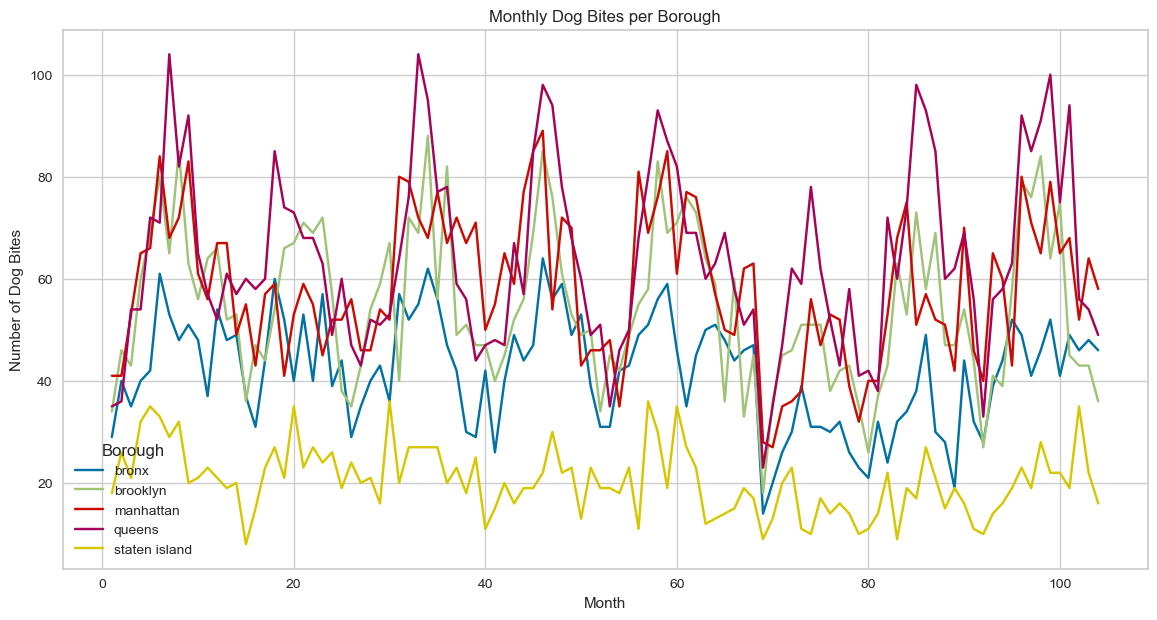

In [41]:
# Aggregate the data by months
monthly_data = time_series_data.copy()

# Group the weeks into months (assuming 4 weeks per month)
for i in range(1, 105):  # 104 months (4 weeks per month)
    month_col = f'month{i}'
    week_cols = [f'week{j}' for j in range((i-1)*4+1, i*4+1)]
    monthly_data[month_col] = monthly_data[week_cols].sum(axis=1)

# Melt the dataframe to long format for seaborn
melted_monthly_data = pd.melt(monthly_data, id_vars=['borough'], value_vars=[f'month{i}' for i in range(1, 105)], var_name='month', value_name='bites')

# Drop rows with NaN values in 'month' column
melted_monthly_data = melted_monthly_data.dropna(subset=['month'])

# Extract month numbers and drop rows with NaN values in 'month' column
melted_monthly_data['month'] = melted_monthly_data['month'].str.extract('(\d+)')
melted_monthly_data = melted_monthly_data.dropna(subset=['month'])

# Convert month to integer for proper plotting
melted_monthly_data['month'] = melted_monthly_data['month'].astype(int)

# Plot using seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=melted_monthly_data, x='month', y='bites', hue='borough')
plt.title('Monthly Dog Bites per Borough')
plt.xlabel('Month')
plt.ylabel('Number of Dog Bites')
plt.legend(title='Borough')

plt.show()